<a href="https://colab.research.google.com/github/DerWeiseTeufel/Tinkoff_Risk_Analytics_2024/blob/main/hw_2_ft_school_boosting_and_feature_selection_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.6 MB/s eta 0:00:00


In [2]:
!pip install libomp

ERROR: Could not find a version that satisfies the requirement libomp (from versions: none)
ERROR: No matching distribution found for libomp


In [3]:
import numpy as np
import pandas as pd
import optuna
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Загрузим данные

- Данные упорядочены по времени
- Задача - предсказать `target`
- Фичи - `feature_i`
- Трейн, валидация и тест уже определены (см. колонку `sample_part`)

In [5]:
path = "/content/drive/MyDrive/Tinkoff/df.parquet.gzip"
df = pd.read_parquet(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 22620 to 310653
Columns: 235 entries, date to sample_part
dtypes: category(2), datetime64[ms](1), datetime64[us](2), float64(220), int64(9), object(1)
memory usage: 893.6+ MB


In [6]:
df.head()

,date,month,quarter,feature_217,feature_66,feature_9,feature_193,feature_15,feature_199,feature_25,...,feature_20,feature_188,feature_71,feature_106,feature_14,feature_92,feature_179,feature_102,target,sample_part
22620,2021-01-01,2021-01-01,2021-01-01,1.180855,0.483118,13.976791,1.135021,43.271792,-46.888875,97.558366,...,23.745198,-32.001093,85.489903,1.454045,-195.725786,3.719083,1,-28.813537,0.0,train
478621,2021-01-01,2021-01-01,2021-01-01,3.427814,0.886778,27.158209,-0.378728,80.087863,-67.242703,105.803406,...,22.902111,-37.436243,71.735619,1.657242,-176.250404,3.277817,1,-45.987721,1.0,train
372254,2021-01-01,2021-01-01,2021-01-01,-38.555018,1.227175,19.893873,0.498787,98.464365,-67.402522,81.858076,...,21.848414,-51.872841,65.363236,1.626874,-178.116798,2.028950,0,-31.074122,1.0,train
2596,2021-01-01,2021-01-01,2021-01-01,-14.666558,0.753129,18.203010,-1.200014,117.331340,-25.557745,90.277266,...,26.134586,-49.703003,65.013659,1.170023,-192.232264,2.218177,1,-36.703897,0.0,train
216892,2021-01-01,2021-01-01,2021-01-01,6.734990,1.129100,11.245920,-0.108955,61.205722,-78.397406,82.637472,...,24.201039,-41.070219,69.986127,1.630795,-200.155528,3.055104,1,-44.672299,1.0,train


In [7]:
TARGET = 'target'
N_FEATURES = 230
features = [f'feature_{i}' for i in range(N_FEATURES)]

# Первичный отбор признаков... (1 балл)

**Задание:** Сначала отсеем совсем уж мусорные признаки.

Воспользовавшись вашим кодом для вычисления `IV` из прошлой домашки, для всех **числовых** фичей вычислите `IV` на 20 бакетах. Отсейте признаки с `IV < 0.005`.

**Hint:** паркет не всегда сохраняет `dtype` колонки. Чтобы проверить признаки на "реальный" тип данных, лучше на всякий случай посмотреть на `nunique`

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
from typing import Union, Tuple

In [9]:
ind_cat = np.where(df[features].nunique()<1000)
cat_features = [features[i] for i in ind_cat[0]]
num_features = [x for x in features if x not in cat_features]

In [10]:
df[num_features].isna().sum()

,0
feature_1,0
feature_2,0
feature_3,30554
feature_4,0
feature_5,0
...,...
feature_225,0
feature_226,45555
feature_227,0
feature_228,63531


num of Categorical featuures = 15

In [ ]:
full_df = df[num_features].fillna(df[num_features].mean())
y = df[TARGET]
IVs = {}
for feature in num_features:
    x = full_df[feature]
    IVs[feature] = calc_feature_info(x, y, 20)['IV']

In [ ]:
IVs_big = { k:v for k, v in IVs.items() if v >= 0.005}

In [ ]:
max(IVs_big.values())

0.03338111716912745

In [ ]:
len(IVs_big.items())

53

**Вопрос**: Почему некорректно сравнивать `IV` у категориальных и числовых фичей?

Вычислите IV для категориальных фичей на `n` бакетах, где `n = min(число категорий фичи, 20)`. Возможно, придётся перекодировать некоторые фичи (*только не OneHot-ом!*)

*Опционально*: примените также и к категориальным фичам предварительный отбор по `IV` с менее строгим порогом

In [ ]:
df[cat_features].isna().sum()/df[cat_features].isna().count()

feature_0      0.000000
feature_10     0.333334
feature_31     0.000000
feature_37     0.000000
feature_62     0.125294
feature_140    0.073886
feature_144    0.000000
feature_147    0.000000
feature_157    0.000000
feature_161    0.102780
feature_165    0.000000
feature_168    0.000000
feature_179    0.000000
feature_209    0.000000
feature_222    0.000000
dtype: float64

In [ ]:
cat_filled_df = df[cat_features].fillna(df[cat_features].mode().iloc[0])

In [ ]:
cat_filled_df.isna().sum()

feature_0      0
feature_10     0
feature_31     0
feature_37     0
feature_62     0
feature_140    0
feature_144    0
feature_147    0
feature_157    0
feature_161    0
feature_165    0
feature_168    0
feature_179    0
feature_209    0
feature_222    0
dtype: int64

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
y = df[TARGET]

for feature in cat_features:
    x = cat_filled_df[feature]
    ord_enc = OrdinalEncoder()
    n = min(x.nunique(), 20)
    x = ord_enc.fit_transform(np.array(x).reshape(-1,1))
    x = x.reshape(1,-1)[0]
    IVs[feature] = calc_feature_info(x, y, n)['IV']

In [ ]:
for f in cat_features:
  print(f, IVs[f])

feature_0 0.0008358691357387304
feature_10 0.0013749759527216954
feature_31 0.012373891296708375
feature_37 0.00012575456432455502
feature_62 0.006243296140479843
feature_140 0.010955370363139604
feature_144 0.013360993295612683
feature_147 0.007958353560070207
feature_157 0.00014195011557541028
feature_161 0.0026034803892762996
feature_165 0.00913622428642341
feature_168 0.006440163058606558
feature_179 6.183068576974373e-07
feature_209 0.02519535296049066
feature_222 7.464729004320941e-07


In [ ]:
len([IVs[f] for f in cat_features if IVs[f]>=0.002])/len(cat_features)

0.6



*   Задача 1: Как преобразовать кат фичу для подсчета IV? - Посмотреть в лекции, пробовал OrdinalEncoder
*   Задача 2: ответ на вопрос поч нельзя сравнивать IV для кат и нум фичей? - мб потому что нум ранжированы по квантилям, а кат нет



In [ ]:
best_cat_features = [f for f in cat_features if IVs[f]>=0.002]
best_num_features = [f for f in num_features if IVs[f]>=0.005]

In [ ]:
print(f" Number of the best numerical features is {len(best_num_features)},\n number of the best categorical features is {len(best_cat_features)}")

 Number of the best numerical features is 53,
 number of the best categorical features is 9


In [ ]:
best_features = best_cat_features + best_num_features
best_features

['feature_31',
 'feature_62',
 'feature_140',
 'feature_144',
 'feature_147',
 'feature_161',
 'feature_165',
 'feature_168',
 'feature_209',
 'feature_2',
 'feature_4',
 'feature_5',
 'feature_9',
 'feature_12',
 'feature_15',
 'feature_23',
 'feature_24',
 'feature_26',
 'feature_27',
 'feature_30',
 'feature_32',
 'feature_35',
 'feature_36',
 'feature_38',
 'feature_39',
 'feature_43',
 'feature_44',
 'feature_46',
 'feature_56',
 'feature_70',
 'feature_75',
 'feature_76',
 'feature_79',
 'feature_94',
 'feature_96',
 'feature_97',
 'feature_98',
 'feature_100',
 'feature_109',
 'feature_111',
 'feature_114',
 'feature_115',
 'feature_117',
 'feature_124',
 'feature_132',
 'feature_135',
 'feature_139',
 'feature_142',
 'feature_154',
 'feature_155',
 'feature_162',
 'feature_164',
 'feature_167',
 'feature_170',
 'feature_172',
 'feature_183',
 'feature_206',
 'feature_213',
 'feature_218',
 'feature_223',
 'feature_225',
 'feature_227']

In [ ]:
df.head()

,date,month,quarter,feature_217,feature_66,feature_9,feature_193,feature_15,feature_199,feature_25,...,feature_20,feature_188,feature_71,feature_106,feature_14,feature_92,feature_179,feature_102,target,sample_part
22620,2021-01-01,2021-01-01,2021-01-01,1.180855,0.483118,13.976791,1.135021,43.271792,-46.888875,97.558366,...,23.745198,-32.001093,85.489903,1.454045,-195.725786,3.719083,1,-28.813537,0.0,train
478621,2021-01-01,2021-01-01,2021-01-01,3.427814,0.886778,27.158209,-0.378728,80.087863,-67.242703,105.803406,...,22.902111,-37.436243,71.735619,1.657242,-176.250404,3.277817,1,-45.987721,1.0,train
372254,2021-01-01,2021-01-01,2021-01-01,-38.555018,1.227175,19.893873,0.498787,98.464365,-67.402522,81.858076,...,21.848414,-51.872841,65.363236,1.626874,-178.116798,2.028950,0,-31.074122,1.0,train
2596,2021-01-01,2021-01-01,2021-01-01,-14.666558,0.753129,18.203010,-1.200014,117.331340,-25.557745,90.277266,...,26.134586,-49.703003,65.013659,1.170023,-192.232264,2.218177,1,-36.703897,0.0,train
216892,2021-01-01,2021-01-01,2021-01-01,6.734990,1.129100,11.245920,-0.108955,61.205722,-78.397406,82.637472,...,24.201039,-41.070219,69.986127,1.630795,-200.155528,3.055104,1,-44.672299,1.0,train


In [11]:
best_features = ['feature_31',
 'feature_62',
 'feature_140',
 'feature_144',
 'feature_147',
 'feature_161',
 'feature_165',
 'feature_168',
 'feature_209',
 'feature_2',
 'feature_4',
 'feature_5',
 'feature_9',
 'feature_12',
 'feature_15',
 'feature_23',
 'feature_24',
 'feature_26',
 'feature_27',
 'feature_30',
 'feature_32',
 'feature_35',
 'feature_36',
 'feature_38',
 'feature_39',
 'feature_43',
 'feature_44',
 'feature_46',
 'feature_56',
 'feature_70',
 'feature_75',
 'feature_76',
 'feature_79',
 'feature_94',
 'feature_96',
 'feature_97',
 'feature_98',
 'feature_100',
 'feature_109',
 'feature_111',
 'feature_114',
 'feature_115',
 'feature_117',
 'feature_124',
 'feature_132',
 'feature_135',
 'feature_139',
 'feature_142',
 'feature_154',
 'feature_155',
 'feature_162',
 'feature_164',
 'feature_167',
 'feature_170',
 'feature_172',
 'feature_183',
 'feature_206',
 'feature_213',
 'feature_218',
 'feature_223',
 'feature_225',
 'feature_227']

In [ ]:

for feature in cat_features:
    x = cat_filled_df[feature]
    ord_enc = OrdinalEncoder()
    x = ord_enc.fit_transform(np.array(x).reshape(-1,1))
    x = x.reshape(1,-1)[0]
    cat_filled_df[feature] = x


# Бустинг

## Подбор гиперпараметров бустинга (2 балла)

Теперь подберем оптимальные гиперпараметры бустинга.

In [12]:
len(best_features)

62

In [13]:
# В переменную features_optuna положите список признаков с предыдущего шага
features_optuna = best_features

**Задание:** Заполните пропуски в коде ниже и подберите оптимальные гиперпараметры.

Для успешного решения необходимо преодолеть порог ROC-AUC `0.725` на тестовой выборке.

In [27]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 5, 1024), #<= 2^max_depth
        'max_depth' : trial.suggest_int('max_depth', 5, 10),
        'n_estimators':trial.suggest_int('n_estimators', 50, 200),
        'min_child_samples':trial.suggest_int('min_child_samples', 20, 40),
        'min_child_weight':trial.suggest_int('min_child_weight', 0.001, 0.01),

        "reg_alpha" : trial.suggest_float("reg_alpha", 0, 1),
        #####
        # your code here
        # Тут вы можете добавить любые гиперпараметры LGBMClassifier (например, что-то из того, что разбирали в лекции)
        #####
        'random_state': 42
    }

    clf = LGBMClassifier(**params)
    clf.fit(
        X=df.loc[df['sample_part'] == 'train', features_optuna],
        y=df.loc[df['sample_part'] == 'train', TARGET]
    )
    preds = clf.predict_proba(df.loc[df['sample_part'] == 'val', features_optuna])[:, 1]
    auc_valid = roc_auc_score(
        y_true=df.loc[df['sample_part'] == 'val', TARGET],
        y_score=preds
    )

    return auc_valid

In [26]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-10-03 10:03:02,910] A new study created in memory with name: no-name-e0b23db0-89f2-4832-b907-668cea46308f


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.336787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13588
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890


[I 2024-10-03 10:03:26,749] Trial 0 finished with value: 0.6964938746964546 and parameters: {'learning_rate': 0.022097649189179048, 'num_leaves': 36, 'max_depth': 7, 'n_estimators': 119, 'min_child_samples': 30, 'min_split_gain': 0.3288738953536547, 'min_child_weight': 0, 'reg_alpha': 0.7832905228163268}. Best is trial 0 with value: 0.6964938746964546.


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13588
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7f27f15130a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-10-03 10:04:08,193] Trial 1 finished with value: 0.7384509995143272 and parameters: {'learning_rate': 0.07252192440148451, 'num_leaves': 820, 'max_depth': 9, 'n_estimators': 143, 'min_child_samples': 39, 'min_split_gain': 0.021384709244885836, 'min_child_weight': 0, 'reg_alpha': 0.4931548935440152}. Best is trial 1 with value: 0.7384509995143272.


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13588
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-03 10:04:19,342] Trial 2 finished with value: 0.7001491845556096 and parameters: {'learning_rate': 0.0925683708767317, 'num_leaves': 738, 'max_depth': 5, 'n_estimators': 52, 'min_child_samples': 38, 'min_split_gain': 0.30566030395283234, 'min_child_weight': 0, 'reg_alpha': 0.040828474829612826}. Best is trial 1 with value: 0.7384509995143272.


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.353475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13588
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-03 10:05:03,787] Trial 3 finished with value: 0.7114553540553668 and parameters: {'learning_rate': 0.01821529831132129, 'num_leaves': 637, 'max_depth': 7, 'n_estimators': 174, 'min_child_samples': 22, 'min_split_gain': 0.16416730289342946, 'min_child_weight': 0, 'reg_alpha': 0.6124037210397472}. Best is trial 1 with value: 0.7384509995143272.


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13588
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-10-03 10:05:29,349] Trial 4 finished with value: 0.729938179698883 and parameters: {'learning_rate': 0.05894365087454457, 'num_leaves': 428, 'max_depth': 8, 'n_estimators': 120, 'min_child_samples': 40, 'min_split_gain': 0.11915799017672024, 'min_child_weight': 0, 'reg_alpha': 0.3392252540530929}. Best is trial 1 with value: 0.7384509995143272.


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13588
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-03 10:06:05,667] Trial 5 finished with value: 0.7331040811073337 and parameters: {'learning_rate': 0.06930228668368983, 'num_leaves': 562, 'max_depth': 10, 'n_estimators': 81, 'min_child_samples': 32, 'min_split_gain': 0.13473142923925452, 'min_child_weight': 0, 'reg_alpha': 0.16744912073476426}. Best is trial 1 with value: 0.7384509995143272.


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13588
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-10-03 10:06:29,237] Trial 6 finished with value: 0.721872179698883 and parameters: {'learning_rate': 0.04623499223891151, 'num_leaves': 834, 'max_depth': 7, 'n_estimators': 125, 'min_child_samples': 22, 'min_split_gain': 0.2642810705900696, 'min_child_weight': 0, 'reg_alpha': 0.45941962544188353}. Best is trial 1 with value: 0.7384509995143272.


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13588
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-10-03 10:06:46,092] Trial 7 finished with value: 0.700510562894609 and parameters: {'learning_rate': 0.03631927855157465, 'num_leaves': 877, 'max_depth': 5, 'n_estimators': 119, 'min_child_samples': 22, 'min_split_gain': 0.07798747748245088, 'min_child_weight': 0, 'reg_alpha': 0.050095036253926195}. Best is trial 1 with value: 0.7384509995143272.


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13588
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-10-03 10:07:01,412] Trial 8 finished with value: 0.6785114239922293 and parameters: {'learning_rate': 0.014557664608844686, 'num_leaves': 677, 'max_depth': 6, 'n_estimators': 78, 'min_child_samples': 34, 'min_split_gain': 0.4463207719669, 'min_child_weight': 0, 'reg_alpha': 0.544279214112757}. Best is trial 1 with value: 0.7384509995143272.


[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13588
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-10-03 10:07:24,560] Trial 9 finished with value: 0.7053720412821759 and parameters: {'learning_rate': 0.02085573671268398, 'num_leaves': 799, 'max_depth': 9, 'n_estimators': 63, 'min_child_samples': 29, 'min_split_gain': 0.18344578952832113, 'min_child_weight': 0, 'reg_alpha': 0.18450442675370382}. Best is trial 1 with value: 0.7384509995143272.


In [28]:
print(study.best_params)

{'learning_rate': 0.07252192440148451, 'num_leaves': 820, 'max_depth': 9, 'n_estimators': 143, 'min_child_samples': 39, 'min_split_gain': 0.021384709244885836, 'min_child_weight': 0, 'reg_alpha': 0.4931548935440152}


In [29]:
#best_params = {'learning_rate': 0.0949962617534754, 'num_leaves': 38, 'max_depth': 20, 'n_estimators': 171, 'min_child_samples': 33, 'min_split_gain': 0.02797103958827727, 'min_child_weight': 0, 'feature_fraction': 0.4836921298663911, 'bagging_fraction': 0.6574469339538627, 'lambda_l1': 4.734161330846415, 'lambda_l2': 1.427886899674426e-05}
best_params = study.best_params
#best_params = study.best_params
clf = LGBMClassifier(**best_params)
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

preds_test = clf.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
auc_test = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)
assert auc_test > 0.725, f'Необходимое значение ROC-AUC 0.725 и выше, ваше значение: {auc_test}!'

[LightGBM] [Info] Number of positive: 177320, number of negative: 72680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.326711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13588
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709280 -> initscore=0.891890
[LightGBM] [Info] Start training from score 0.891890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

## Кривые накопления (1 балл)

**Задание:** Отрисуйте кривые накопления `ROC AUC` от `n_estimators` для бустинга с гиперпараметрами из предыдущего пункта.

**Hint:** для получения auc на каждой итерации обучения `LGBMClassifier`, можно воспользоваться параметрами `eval_set`, `eval_metric` и в методе `fit`.

[LightGBM] [Warning] feature_fraction is set=0.595337334984244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.595337334984244
[LightGBM] [Warning] lambda_l2 is set=1.7361764431026353e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7361764431026353e-07
[LightGBM] [Warning] lambda_l1 is set=7.022829989145922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.022829989145922
[LightGBM] [Warning] bagging_fraction is set=0.9427820089515856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9427820089515856
[LightGBM] [Warning] feature_fraction is set=0.595337334984244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.595337334984244
[LightGBM] [Warning] lambda_l2 is set=1.7361764431026353e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7361764431026353e-07
[LightGBM] [Warning] lambda_l1 is set=7.022829989145922, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.022829989145922
[Li

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

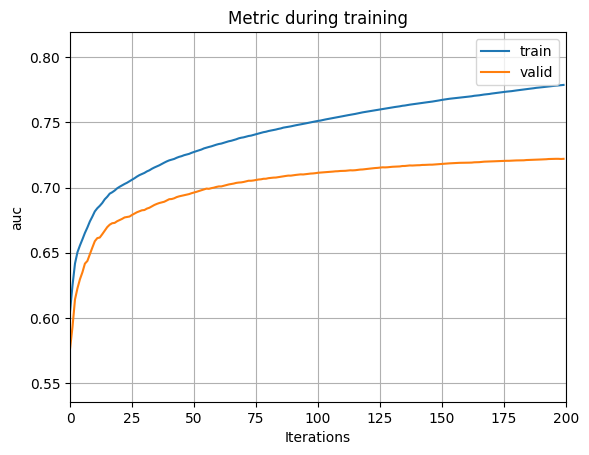

In [ ]:
from lightgbm import plot_metric
X_train, y_train = df.loc[df['sample_part'] == 'train', features_optuna], df.loc[df['sample_part'] == 'train', TARGET]
X_eval, y_eval = df.loc[df['sample_part'] == 'test', features_optuna], df.loc[df['sample_part'] == 'test', TARGET]
fit_params = {"eval_metric" : "auc", "eval_set" : [(X_train,y_train), (X_eval,y_eval)], "eval_names" : ['train', 'valid']}
best_params = {'learning_rate': 0.09982671866973009, 'num_leaves': 39, 'max_depth': 18, 'n_estimators': 200, 'min_child_samples': 40, 'min_split_gain': 0.19276686814030589, 'min_child_weight': 0, 'feature_fraction': 0.595337334984244, 'bagging_fraction': 0.9427820089515856, 'lambda_l1': 7.022829989145922, 'lambda_l2': 1.7361764431026353e-07}

clf = LGBMClassifier(**best_params)
clf.fit(
    X=X_train,
    y=y_train,
    eval_set = [(X_train, y_train), (X_eval, y_eval)],
    eval_metric = "auc",
    eval_names=['train', 'valid']
)
plot_metric(clf,metric='auc')

**Вопрос:** Что вы видите на полученных графиках?

Нужно ли "обрезать" количество деревьев? Ответ обоснуйте.

Ответ: на графике видно что AUC на трейне растет быстрее чем на тесте, я думаю обрезать деревья до 140  следует, потому что auc практические не увеличивается. В то же время AUC на тесте всегда хуже чем на трейне, я думаю, что модели стало плохо гораздо раньше.

## Важность признаков (1 балл)

**Задание:** Постойте гистограмму важности признаков по `split` и `gain` для бустинга из предыдущего пункта.

<Axes: title={'center': 'LightGBM feature importance(GAIN)'}, xlabel='Feature importance', ylabel='Features'>

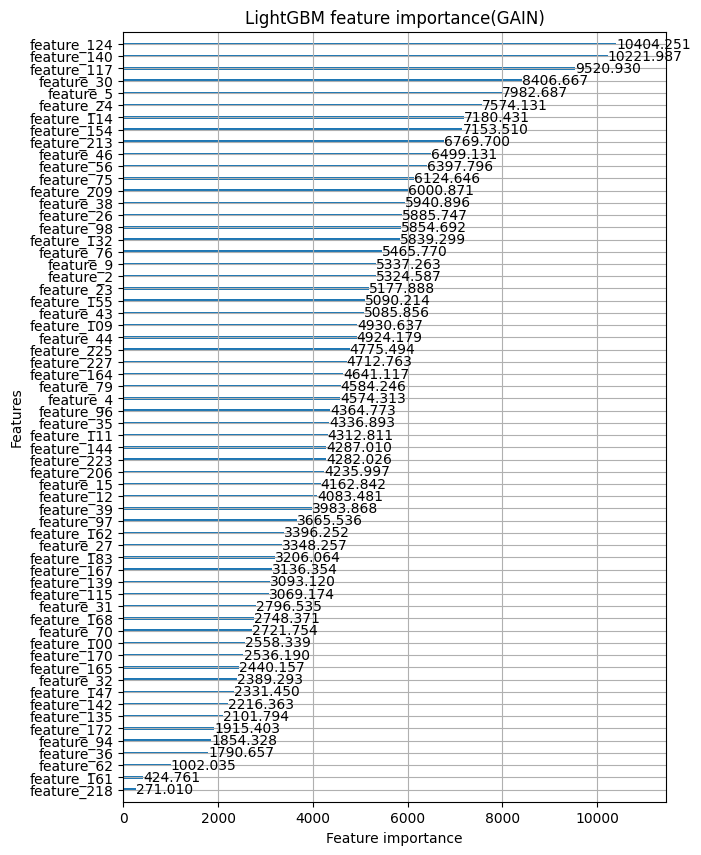

In [ ]:
#####
from lightgbm import plot_importance
plot_importance(clf, importance_type='gain', figsize=(7,10), title='LightGBM feature importance(GAIN)')
#####

In [ ]:
import plotly.express as px
clf.importance_type = "gain"
gain_importance = clf.feature_importances_
gain_importance_df = pd.DataFrame({'Feature': best_features, 'Gain': gain_importance})
fig = px.histogram(gain_importance_df, x = 'Feature', y='Gain')
fig.show()

<Axes: title={'center': 'LightGBM feature importance(SPLIT)'}, xlabel='Feature importance', ylabel='Features'>

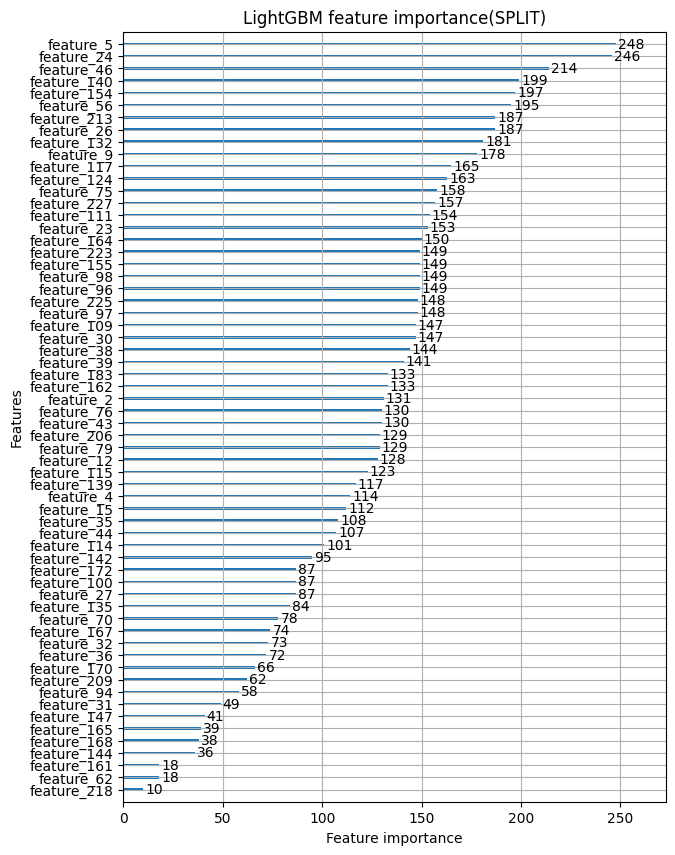

In [ ]:
#####
from lightgbm import plot_importance
plot_importance(clf, importance_type='split', figsize=(7,10),title='LightGBM feature importance(SPLIT)')
#####

In [ ]:
import plotly.express as px
clf.importance_type = "split"
gain_importance = clf.feature_importances_
gain_importance_df = pd.DataFrame({'Feature': best_features, 'Split': gain_importance})
fig = px.histogram(gain_importance_df, x = 'Feature', y='Split')
fig.show()

**Вопрос:** Какие выводы можно сделать из полученных графиков?

Ответ: важность фичей распределена нормально

In [ ]:
gain_importance = clf.feature_importances_
len(gain_importance)

62

In [ ]:
clf.importance_type = "gain"
gain_importance = clf.feature_importances_
gain_importance_df = pd.DataFrame({'Feature': best_features, 'Gain': gain_importance})
print(gain_importance_df.sort_values(by='Gain', ascending=False))

        Feature          Gain
43  feature_124  10502.612873
2   feature_140  10180.389417
42  feature_117   9595.118999
19   feature_30   9350.199259
11    feature_5   6964.616019
..          ...           ...
33   feature_94   1974.892612
22   feature_36   1588.058088
1    feature_62   1111.658914
5   feature_161    391.279538
58  feature_218    361.213000

[62 rows x 2 columns]


In [ ]:
gain_importance_df.sort_values(by='Gain', ascending=False).Feature[:15]

43    feature_124
2     feature_140
42    feature_117
19     feature_30
11      feature_5
16     feature_24
57    feature_213
40    feature_114
27     feature_46
15     feature_23
48    feature_154
8     feature_209
44    feature_132
23     feature_38
31     feature_76
Name: Feature, dtype: object

# Логрег

## plot_metric_time (1 балл)

**Задание:** Реализуйте функцию plot_metric_time, которая будет принимать на вход четыре аргумента, а именно:
- массив значений фичи,
- массив значений таргета,
- массив времени (аггрегированного по месяцам или кварталам, то есть `month` или `quarter` в вашей задаче, по дням рисовать не надо),
- метрику, которую необходимо отрисовать (нужно реализовать функцию для двух метрик: `IV` и `roc_auc`)
- число бакетов для вычисления `IV`, если выбрана эта метрика

Можете добваить какие-то ещё аргументы, если вам нужно

Если в фиче есть пропуски, функция должна убирать строки с пропусками из рассмотрения

**Hint**: можно, конечно, реализовать эту функцию через цикл, а можно попробовать разобраться и реализовать её через пандасовские `groupby` -> `apply`, это изящнее и быстрее

In [ ]:
import plotly.graph_objects as go

In [ ]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на
    n_buckets бакетов"""
    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)
    return buckets

In [ ]:
from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    badrate = np.vectorize(lambda x:  0.001 if x<=0 else( 0.999 if x>=1 else x))(badrate)
    woe = logit(badrate) - offset
    return woe

In [ ]:
def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""
    # считаем бэдрейт и доверительный интервал для него (любым способом)
    #buckets array: index of an object -> index of the bucket
    # target: index of an object -> value of {0, 1}
    target = pd.Series(target)
    n = target.groupby(buckets).count()
    bad = target.groupby(buckets).sum()
    """
    p_hat = bad/n
    alpha = 0.05
    norm_rv = sps.norm()
    z_crit = norm_rv.ppf(1 - alpha/2)

    badrate, badrate_lower, badrate_upper = p_hat, p_hat - z_crit*np.sqrt(p_hat*(1-p_hat)/n) , p_hat + z_crit*np.sqrt(p_hat*(1-p_hat)/n)
    # переходим от бэдрейта к woe

    woe, woe_lower, woe_upper = woe_transform(badrate, 0), woe_transform(badrate_lower, 0), woe_transform(badrate_upper, 0)
    """
    bad_rate = bad/n
    se = np.sqrt(bad_rate * (1 - bad_rate) / n)
    alpha = 0.05

    z_crit = sps.norm.ppf(1 - alpha/2)

    ci_lower = np.maximum(0.00001, bad_rate - z_crit * se)
    ci_upper = np.minimum(1-0.00001, bad_rate + z_crit * se)

    # Применяем woe_transform к границам доверительного интервала
    woe_lower = woe_transform(ci_lower, offset)
    woe_upper = woe_transform(ci_upper, offset)
    woe = woe_transform(bad_rate, offset)
    woe_lower =  woe - woe_lower
    woe_upper = woe_upper - woe
    return woe, woe_lower, woe_upper

In [ ]:
from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""
    log_Reg = LogisticRegression()
    log_Reg.fit(np.array(values).reshape(-1, 1), target)
    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    proba = log_Reg.predict_proba(np.array(mean_feature).reshape(-1, 1))

    line = woe_transform(proba[:,1], offset)
    return line

In [ ]:
def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""
    offset = logit(target.sum() / len(target))
    avg = pd.Series(values).groupby(buckets).mean()
    line = calc_line(values, target, avg, offset)
    woe, woe_lower, woe_upper = woe_ci(target, buckets, offset )
    buckets_info = {
        "mean_feature" : avg,
        "line"         : line,
        "woe"          : woe,
        "woe_lower"    : woe_lower,
        "woe_upper"    : woe_upper
    }

    return buckets_info

In [ ]:
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.linear_model import LogisticRegression

def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    target = pd.Series(target)
    b_i = target.groupby(buckets).sum()
    g_i = target.groupby(buckets).count() - b_i
    b = target.sum()
    g = target.count() - b

    offset = logit(target.sum() / len(target))

    woe_i = woe_transform(b_i/(b_i+g_i), offset) - woe_transform(b/(b+g),offset)

    auc = roc_auc_score(target, (b_i/(b+g))[buckets])
    # формула выше


    IV =((b_i/b-g_i/g)*woe_i).sum()

    # Взвешенный R^2
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    X = pd.Series(values).groupby(buckets).mean() # works

    Y = woe_i#np.log(b_i/g_i) - np.log(b/g)# works
    w = pd.Series(values).groupby(buckets).count() #works
# "Да, короче при расчете R^2 X – предсказание логрега в точке - среднее в бакете, Y – WoE в бакете" - Will Smith
    logReg = LogisticRegression()
    logReg.fit(np.array(values).reshape(-1,1), target)
    X = logReg.predict_proba(np.array(X).reshape(-1,1))[:,1]
    X = woe_transform(X, offset)
    weights = np.bincount(buckets)
    R_sqr = r2_score(Y, X, sample_weight=w)

    plot_title = (
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

In [ ]:
# в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

In [ ]:
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.linear_model import LogisticRegression

def calc_feature_info(
        values : np.ndarray,
        target : np.ndarray,
        bucket_num : int
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    values = pd.Series(values)
    target = pd.Series(target)
    # !DROPPING  NAN HERE
    target = target[values.dropna().index].reset_index(drop=True)

    values = values.dropna().reset_index(drop=True)
    buckets = calc_buckets(values, bucket_num)
    b_i = target.groupby(buckets).sum()
    g_i = target.groupby(buckets).count() - b_i
    b = target.sum()
    g = target.count() - b
    offset = logit(target.sum() / len(target))

    woe_i = woe_transform(b_i/(b_i+g_i), offset) - woe_transform(b/(b+g),offset)

    auc = roc_auc_score(target, (b_i/(b+g))[buckets])
    # формула выше


    IV =((b_i/b-g_i/g)*woe_i).sum()

    # Взвешенный R^2
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    X = values.groupby(buckets).mean() # works

    Y = woe_i#np.log(b_i/g_i) - np.log(b/g)# works
    w = values.groupby(buckets).count() #works

# "Да, короче при расчете R^2 X – предсказание логрега в точке - среднее в бакете, Y – WoE в бакете" - Will Smith
    logReg = LogisticRegression()
    logReg.fit(np.array(values).reshape(-1,1), target)
    X = logReg.predict_proba(np.array(X).reshape(-1,1))[:,1]
    X = woe_transform(X, offset)
    weights = np.bincount(buckets)
    R_sqr = r2_score(Y, X, sample_weight=w)

    info_feature = {
        "AUC":auc,
        "IV": IV,
        "R_sqr" :R_sqr
    }

    return info_feature

In [ ]:
def plot_metric_time(
        values: pd.Series,
        target: pd.Series,
        time: pd.Series,
        metric: str = 'IV',
        n_buckets_for_IV: int = 15
) -> go.Figure:
    metric_values = []
    if metric == 'IV':
      for time_span in time.unique():
        x = values[time==time_span]
        y = target[time==time_span]
        #buckets = calc_buckets(x, n_buckets_for_IV)
        buckets=n_buckets_for_IV
        IV_cur = calc_feature_info(x, y, buckets)['IV']
        metric_values.append(IV_cur)
      #return metric_values
    elif metric == 'roc_auc':
      for time_span in time.unique():
        x = values[time==time_span]
        y = target[time==time_span]
        #buckets = calc_buckets(x, n_buckets_for_IV)
        buckets=n_buckets_for_IV

        AUC_cur = calc_feature_info(x, y, buckets)['AUC']
        metric_values.append(AUC_cur)
    else:
        raise NotImplementedError("only 'IV' and 'roc_auc' metrics are implemented")

    # your code here

    plot_title = f"{metric} plot"
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x= time.unique(),# месяцы или кварталы, your code here
            y= metric_values,# аггрегированное значение метрики, your code here
            mode='markers+lines',
            name=metric# имя фичи, your code here
            ))
    fig.update_layout(
            title_text=plot_title,
            yaxis=dict(title=metric),
            width=1000,
            height=450,
            xaxis=dict(
                domain=[0, .95],
                showgrid=True,
                tickvals=time.unique()# месяцы или кварталы, your code here
                ),
            margin=dict(l=30, r=30, b=30, t=50),
            )
    fig.show()
    #return fig

In [ ]:
plot_metric_time(df[best_features[0]], df[TARGET], df['month'], 'roc_auc')

**Задание:** Возьмите **топ-15** фичей получившегося бустинга по важности по `gain`. Отрисуйте для них графики стабильности по `IV` во времени и удалите из рассмотрения те признаки, качество которых деградирует

**NB!** Обращайте внимание на масштаб оси *y!* Иногда признак стабильнее, чем кажется)

Если вам это мешает, можете поменять ось *y*, чтобы она начиналась от нуля в прошлом задании.

In [ ]:
clf.importance_type = "gain"
gain_importance = clf.feature_importances_
gain_importance_df = pd.DataFrame({'Feature': best_features, 'Gain': gain_importance})

top15features_stable = gain_importance_df.sort_values(by='Gain', ascending=False).Feature[:15].tolist()
top15features_stable

['feature_124',
 'feature_140',
 'feature_117',
 'feature_30',
 'feature_5',
 'feature_24',
 'feature_114',
 'feature_154',
 'feature_213',
 'feature_46',
 'feature_56',
 'feature_75',
 'feature_209',
 'feature_38',
 'feature_26']

In [ ]:
top15features_stable = ['feature_124',
 'feature_140',
 'feature_117',
 'feature_30',
 'feature_5',
 'feature_24',
 'feature_114',
 'feature_154',
 'feature_213',
 'feature_46',
 'feature_56',
 'feature_75',
 'feature_209',
 'feature_38',
 'feature_26']

### top[0] - feature_124

In [ ]:
x = top15features_stable[0]
x

'feature_124'

#### IV (month)

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV (quarter)

In [ ]:
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: оставляем

### top[1] - 'feature_140'

In [ ]:
x = top15features_stable[1]
x

'feature_140'

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV quarter

In [ ]:
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: оставляем

### top[2] - 'feature_117'

In [ ]:
x = top15features_stable[2]
x

'feature_117'

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV quarter

In [ ]:
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: оставляем

### top[3] - 'feature_30'

In [ ]:
x = top15features_stable[3]
x

'feature_30'

#### IV month

In [ ]:
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV quarter

In [ ]:
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: оставляем

### top15[4] - 'feature_5'

In [ ]:
x = top15features_stable[4]
x

'feature_5'

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV quarter

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: оставляем

### top15[5] - 'feature_24'

In [ ]:
x = top15features_stable[5]
x

'feature_24'

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV quarter

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: оставляем

### top15[6] - 'feature_114' -

In [ ]:
x = top15features_stable[6]
x

'feature_114'

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV quarter

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: удаляем

### top[7] - 'feature_154' -

In [ ]:
x = top15features_stable[7]
x

'feature_154'

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: удаляем

### top[8] - 'feature_209'

In [ ]:
x = top15features_stable[8]
x

'feature_213'

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: оставляем

### top[9] - 'feature_46'

In [ ]:
x = top15features_stable[9]
x

'feature_46'

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV quarter

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: оставляем

### top[10] - 'feature_56'

In [ ]:
x = top15features_stable[10]
x

'feature_56'

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV quarter

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: оставляем

### top[11] - 'feature_75'

In [ ]:
x = top15features_stable[11]
x

'feature_75'

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV quarter

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: оставляем

### top[12] - 'feature_209'

In [ ]:
x = top15features_stable[12]
x

'feature_209'

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ord = OrdinalEncoder()
transformed_x = ord.fit_transform(np.array(df[x]).reshape(-1,1)).reshape(1,-1)
transformed_x = pd.Series(transformed_x[0])
transformed_x

NameError: name 'np' is not defined

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(transformed_x, df['target'], df['month'], 'IV') #

#### IV quarter

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(transformed_x, df['target'], df['quarter'], 'IV') #

Вердикт: оставляем

### top[13] - 'feature_38' -

In [ ]:
x = top15features_stable[13]
x

'feature_38'

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV quarter

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: удаляем

### top[14] - 'feature_26' +

In [ ]:
x = top15features_stable[14]
x

'feature_26'

#### IV month

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['month'], 'IV') #

#### IV quarter

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df[x], df['target'], df['quarter'], 'IV') #

Вердикт: оставляем

### Оставшиеся фичи

In [ ]:
top15features_stable = ['feature_124',
 'feature_140',
 'feature_117',
 'feature_30',
 'feature_5',
 'feature_24',
 'feature_114',
 'feature_154',
 'feature_213',
 'feature_46',
 'feature_56',
 'feature_75',
 'feature_209',
 'feature_38',
 'feature_26']

In [ ]:
top_12_features_stable_time = ['feature_124',
 'feature_140',
 'feature_117',
 'feature_30',
 'feature_5',
 'feature_24',
 #'feature_114',
 #'feature_154',
 'feature_213',
 'feature_46',
 'feature_56',
 'feature_75',
 'feature_209',
 #'feature_38',
 'feature_26']

На этом моменте предлагаю сделать новый маленький датафрейм, чтобы не "портить" исходный

И проводить все манипуляции с фичами на нём

In [ ]:
df_for_logreg = df[top_12_features_stable_time + ['date', 'month', 'quarter', 'target', 'sample_part']]

## Предобработка признаков (2 балла)

**Задание:** Используя функицю woe_line из предыдущего ДЗ, проверьте **числовые** фичи из полученного списка фичей на линейность по WoE на трейн-выборке (если в фиче есть пропуски - дропаем их при отрисовке)

Если фичи нелинейные, **линеаризуйте их**.

Преобразования, которые можно/стоит пробовать:
- клипы (`np.clip`) - зачастую их достаточно
- корень
- квадрат
- логарифм

Если нужно, можно прибавлять к фиче константу или менять её знак

При желании можно "распилить фичу на две половины" (если она немонотонна) и линеаризовать их по отдельности

Однако слишком упираться в линеаризацию фичей не нужно. Если фича ну совсем никак не линеаризуется, в крайнем случае можно её дропнуть или оставить как есть.

При отрисовке можно ограничиться 15-20 бактеами

### feature_124 A

#### before

In [ ]:
f_name = top_12_features_stable_time[0]
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
woe_line(x, y, n_bucks)

#### after

In [ ]:
f_name = top_12_features_stable_time[0]
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
x = np.clip(x,-62,-32)
woe_line(x, y, n_bucks)

Вердикт: хорошая линейность

### feature_140 A

In [ ]:
f_name = top_12_features_stable_time[1]
f_name

'feature_140'

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
woe_line(x, y, n_bucks)

Вердикт: линейность неплохая

### feature_117 A

In [ ]:
f_name = top_12_features_stable_time[2]
f_name

'feature_117'

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
woe_line(x, y, n_bucks)

Вердикт: классная линейность

### Feature_30 A

In [ ]:
f_name = top_12_features_stable_time[3]
f_name

'feature_30'

#### before

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
woe_line(x, y, n_bucks)

#### after

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
x = np.sqrt(x)
woe_line(x, y, n_bucks)

Вердикт: классная линейность

### feature_5 C

In [ ]:
f_name = top_12_features_stable_time[4]
f_name

'feature_5'

#### before

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
woe_line(x, y, n_bucks)

#### after

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
x = np.clip(x, -220, -80)

woe_line(x, y, n_bucks)

вердикт: оставим, но кандидат на вылет

### feature_24 A

In [ ]:
f_name = top_12_features_stable_time[5]
f_name

'feature_24'

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
woe_line(x, y, n_bucks)

Вердикт: классная линейность

### feature_213 D

In [ ]:
f_name = top_12_features_stable_time[6]
f_name

'feature_213'

#### before

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
woe_line(x, y, n_bucks)

#### after

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15

x = np.clip(x, 6, 18)
x = np.log(x)
woe_line(x, y, n_bucks)

Вердикт: можно дропнуть

###feature_46 A

In [ ]:
f_name = top_12_features_stable_time[7]
f_name

'feature_46'

#### before

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
woe_line(x, y, n_bucks)

#### after

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
x = np.clip(x, -200, 400)
x = x + 201
x = np.log(x)
x = np.clip(x, 2,10)
woe_line(x, y, n_bucks)

Вердикт: транформации помогли, линейность хорошая, оставим. плохо что из-за трансформаций понизилось IV

### feature_56 C

In [ ]:
f_name = top_12_features_stable_time[8]
f_name

'feature_56'

#### Before

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
woe_line(x, y, n_bucks)

#### After

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
x = np.clip(x, -400, 200)
woe_line(x, y, n_bucks)

Вердикт: линейность не очень хорошая, оставим, но первая на вылет

### feature_75 A

In [ ]:
f_name = top_12_features_stable_time[9]
f_name

'feature_75'

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
woe_line(x, y, n_bucks)

Вердикт: линейность классная

###feature_209 A

In [ ]:
f_name = top_12_features_stable_time[10]
f_name

'feature_209'

#### before

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
from sklearn.preprocessing import OrdinalEncoder
ord = OrdinalEncoder()
transformed_x = ord.fit_transform(np.array(x).reshape(-1,1)).reshape(1,-1)
transformed_x = pd.Series(transformed_x[0])
x = transformed_x
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
woe_line(x, y, n_bucks)

#### after

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
from sklearn.preprocessing import OrdinalEncoder
ord = OrdinalEncoder()
transformed_x = ord.fit_transform(np.array(x).reshape(-1,1)).reshape(1,-1)
transformed_x = pd.Series(transformed_x[0])
x = transformed_x
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
x = np.clip(x, 1,2)
woe_line(x, y, n_bucks)

Вердикт: линейность хорошая после трансформации

### feature_26 B

In [ ]:
f_name = top_12_features_stable_time[11]
f_name

'feature_26'

In [ ]:
xy = df.loc[df['sample_part'] == 'train', [f_name, TARGET]].dropna()
x = xy.iloc[:,0]
y = xy.iloc[:,1]
if x.nunique() < 1000:
  n_bucks = x.nunique()
else:
  n_bucks = 15
woe_line(x, y, n_bucks)

Вердикт: пытался клипить, лучше не получается, оставляем, линейность неплохая

## получившиеся признаки:

In [ ]:
top_12_features_stable_time

['feature_124',
 'feature_140',
 'feature_117',
 'feature_30',
 'feature_5',
 'feature_24',
 'feature_213',
 'feature_46',
 'feature_56',
 'feature_75',
 'feature_209',
 'feature_26']

In [ ]:
features_after_woe = [
 'feature_124',
 'feature_140',
 'feature_117',
 'feature_30',
 #'feature_5',
 'feature_24',
 #'feature_213',
 'feature_46',
 #'feature_56',
 'feature_75',
 'feature_209',
 'feature_26']

Пришло время заполнить пропуски.

Самый простой вариант для числовых признаков - заполнить их средним значением фичи

**Вопрос**: какие проблемы могут возникнуть при таком заполнении пропусков?

**Задание**: Проверьте, что заполнение средним значением адекватно для тех признаков, где есть пропуски (hint: в нашем датасете - почти всегда адекватно). Если нет, придумайте, как ещё можно заполнить пропуски. Ну и заполните их)

Ответ: Потому что такой способ уменьшает variance фичей. Чем меньше variance тем меньше информативность признаков

In [ ]:
df_for_logreg.head()

,feature_124,feature_140,feature_117,feature_30,feature_5,feature_24,feature_213,feature_46,feature_56,feature_75,feature_209,feature_26,date,month,quarter,target,sample_part
22620,-61.495238,15.0,-17.226707,0.036732,-215.945717,-7.179830,7.458468,115.319640,-258.724816,-37.566036,PRIV,45.123716,2021-01-01,2021-01-01,2021-01-01,0.0,train
478621,-28.477404,28.0,-8.564242,0.059557,-170.713568,-23.797875,10.884534,172.981221,-75.131292,-51.686117,GVM,33.405854,2021-01-01,2021-01-01,2021-01-01,1.0,train
372254,NaN,10.0,-10.249472,0.083588,-154.503339,-22.976857,17.206131,-119.580242,-270.127459,-32.603922,UNEMP,-186.825975,2021-01-01,2021-01-01,2021-01-01,1.0,train
2596,-42.117574,22.0,-13.114987,0.021008,-131.553444,-14.087877,18.618423,85.009499,-463.492274,-45.032987,PRIV,-74.749292,2021-01-01,2021-01-01,2021-01-01,0.0,train
216892,-48.599477,50.0,-7.378194,0.090340,-162.092621,-17.195954,8.274292,43.108790,327.178077,-58.049155,UNEMP,186.120862,2021-01-01,2021-01-01,2021-01-01,1.0,train


### Новый датафрейм

In [ ]:
df_for_logreg = df_for_logreg.drop(labels=[x for x in  top_12_features_stable_time if x not in features_after_woe],axis=1)

In [ ]:
df_for_logreg = df[features_after_woe + ['date', 'month', 'quarter', 'target', 'sample_part']]

Вспомним про категориальные признаки, их нужно закодировать.

**Задание:** Используя `OneHotEncoder` закодируйте категориальные признаки.

Ответ:Не понял как должен работать stepwise feature selection на onehotencoded фичах, поэтому везде кодировал с OrdinalEncoder с помощью ColumnTransformer

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
results = enc.fit_trasnform(df[cat_features])
df = df.join(results)
df.head()
# your code here

## Stepwise и обучение логрега (3 балла)

**Задание (boss)**: Реализуйте Stepwise-алгоритм.

Ваша функция `stepwise` должна принимать на вход:
- Датафрейм со всеми признаками и таргетом
- список с именами рассматриваемых признаков
- строку-имя таргета
- уровни значимости `alpha_in` и `alpha_out`

И возвращать список отобранных признаков.

Во время работы пусть она также выводит, какой признак был включён или исключён и с каким `p-value`

### LogReg on top15features_stable + woe transform

In [ ]:
df_for_logreg = df[top15features_stable + ['date', 'month', 'quarter', 'target', 'sample_part']]

#### Stepwise function

In [ ]:
from scipy.stats.distributions import chi2
from sklearn.metrics import log_loss

In [ ]:
def likelihood_ratio_test(ll_short, ll_long):

    """
    вспомогательная функция
    рассчитывает значение p-value для теста отношения правдоподобия
    ll_short — логарифм правдоподобия модели на k переменных
    ll_long — логарифм правдоподобия модели на k+1 переменной

    Returns
    -----
    p-value
    """
    lr = -2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [ ]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

def stepwise(
        df: pd.DataFrame,
        features: list[str],
        target: str,
        alpha_in: float = 0.01,
        alpha_out:  float = 0.05
        ) -> list[str]:


    selected_features = list()

    while True:

        # forward:
        best_feature = None
        if (len(selected_features) < len(features)):
          p_value = alpha_in
          for feature in set(features) - set(selected_features):
          # features without potential feature
            # create X and y for short
            X_short, y_short = df[selected_features], df[target]
            # indices of cat features in short
            #ind_cat_short = df[features].columns[df[features].dtypes != 'int64']#np.where(df[features_short].nunique()<1000)
            # cat_features in short
            #categorical_features_short = [f for f in ind_cat_short]#[features[i] for i in ind_cat_short[0]]
            #numerical_features_short = [x for x in features if x not in categorical_features_short]

            # logReg pipeline short
            logReg_short = LogisticRegression()

            # if feature's values have less than 1k unique values than it's add it to cat features, else to num features


            # LogReg
            logReg_long = LogisticRegression()
            #print("long",logReg_long)

            if len(selected_features) == 0:
                X_short = np.zeros(df[target].shape).reshape(-1,1)
                logReg_short = LogisticRegression()

            # LogReg for short training

            logReg_short.fit(X_short, y_short)
            # get probabilities for training
            proba_short = logReg_short.predict_proba(X_short)[:,1]
            # LogLoss for short
            ll_short = -log_loss(y_short, proba_short,normalize=False)
            # training long
            X_long, y_long = df[selected_features + [feature]], df[target]

            logReg_long.fit(X_long, y_long)
            # probability
            proba_long = logReg_long.predict_proba(X_long)[:,1]
            # long LogLoss
            ll_long = -log_loss(y_long, proba_long, normalize=False)

            # calc_p_value and find feature with min p_value
            p_value_cur = likelihood_ratio_test(ll_short, ll_long)
            #print(p_value_cur)
            if p_value_cur<p_value: # p_value_start = alpha_in
              p_value = p_value_cur
              best_feature = feature

            # your code here


          if best_feature:
                selected_features.append(best_feature)
                print(f"В модель была добавлена переменная {best_feature}, p-value: {round(p_value, 6)}")


        # backward
        worst_feature = None
        if (len(selected_features) > 1):
          p_value = alpha_out
          logReg_long = LogisticRegression()
          X_long, y_long = df[selected_features], df[target]
          logReg_long.fit(X_long, y_long)
          proba_long = logReg_long.predict_proba(X_long)[:,1]
          ll_long = -log_loss(y_long, proba_long, normalize=False)

          for feature in selected_features:
            X_short, y_short = df[[x for x in selected_features if x != feature]], df[target]

            # logReg pipeline short
            logReg_short = LogisticRegression()


            logReg_short.fit(X_short, y_short)
            # get probabilities for training
            proba_short = logReg_short.predict_proba(X_short)[:,1]
            # LogLoss for short
            ll_short = -log_loss(y_short, proba_short,normalize=False)


            # calc_p_value and find feature with min p_value
            p_value_cur = likelihood_ratio_test(ll_short, ll_long)

            if p_value_cur>=p_value: # p_value_start = alpha_out
              p_value = p_value_cur
              worst_feature = feature


            # your code here


          if worst_feature:
              selected_features.remove(worst_feature)
              print(f"Из модели была удалена переменная {worst_feature}, p-value: {round(p_value, 6)}")

        if not (best_feature or worst_feature):
            break # но вы можете сформулировать критерий останова по-другому, если вам так будет удобнее писать

    return selected_features

Запустите ваш алгоритм на отобранных фичах со значениями `alpha_in = 0.01`, `alpha_out = 0.02`

Если в степвайз заходят *все переменные*, причём с очень маленькими `p-value` - это неудивительно, ведь вы уже провели серьёзный предварительный отбор фичей.

Чтобы убедиться в коректности работы своего алгоритма, можете попробовать запустить его на каких-нибудь других фичах, откинутых сильно ранее

#### Preprocessing for stepwise alg

In [ ]:
from sklearn.preprocessing import FunctionTransformer

@FunctionTransformer
def f124_transform(x):
    return np.clip(x, -62,-32)

@FunctionTransformer
def f30_transform(x):
    return np.sqrt(x)

@FunctionTransformer
def f46_transform(x):
    return np.clip(np.log(np.clip(x, -200, 400) + 201), 2,10)

@FunctionTransformer
def f209_transform(x):
    return np.clip(x, 1,2)



In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
selected_features = features_after_woe
numerical_features = df_for_logreg[selected_features].select_dtypes(include=["number"]).columns.tolist()

categorical_features = df_for_logreg[selected_features].select_dtypes(exclude=["number"]).columns.tolist()


woe_transformer = ColumnTransformer(transformers=[    ('f1', (f124_transform), ['feature_124']),
    ('f2', (f30_transform),['feature_30']),
    ('f3', (f46_transform), ['feature_46'])],
                                      remainder='passthrough',
                                      verbose_feature_names_out=False)

numerical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])

categorical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value="missing")),
                ('ordinal', OrdinalEncoder())
            ])

preprocessor_pipeline = ColumnTransformer(transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)

            ], remainder='passthrough',verbose_feature_names_out=False
            )
woe_transformer_post = ColumnTransformer(transformers=[    ('f209', (f209_transform), ['feature_209'])],
                                      remainder='passthrough',
                                      verbose_feature_names_out=False)
preprocessor_pipeline.set_output(transform="pandas")
woe_transformer.set_output(transform="pandas")
woe_transformer_post.set_output(transform="pandas")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning:

With transform="pandas", `func` should return a DataFrame to follow the set_output API.



ColumnTransformer(remainder='passthrough',
                  transformers=[('f209',
                                 FunctionTransformer(func=<function f209_transform at 0x7eaf71a39090>),
                                 ['feature_209'])],
                  verbose_feature_names_out=False)

#### Creating new df for stepwise algorithm

Нормализация + кодирование  + линерализация

In [ ]:
from sklearn.linear_model import LogisticRegression

preprocess_stepwise = Pipeline([('woe', woe_transformer), ('scaling', preprocessor_pipeline), ('woe_post', woe_transformer_post) ])
new_df_for_logreg = preprocess_stepwise.fit_transform(df_for_logreg)
new_df_for_logreg


,feature_209,feature_124,feature_140,feature_117,feature_30,feature_24,feature_46,feature_75,feature_26,date,month,quarter,target,sample_part,logreg,logit_logreg
22620,1.0,-2.143115,-1.121778,-1.706121,0.515643,0.547413,0.493202,0.409315,0.625352,2021-01-01,2021-01-01,2021-01-01,0.0,train,0.443837,-0.225604
478621,1.0,1.259866,-0.207298,0.397223,1.227389,-1.282936,0.623483,-0.744185,0.522796,2021-01-01,2021-01-01,2021-01-01,1.0,train,0.684474,0.774407
372254,2.0,0.107822,-1.473501,-0.011970,1.839739,-1.192507,-0.562676,0.814681,-1.404701,2021-01-01,2021-01-01,2021-01-01,1.0,train,0.607502,0.436826
2596,1.0,0.092562,-0.629366,-0.707749,-0.118997,-0.213455,0.414833,-0.200676,-0.423792,2021-01-01,2021-01-01,2021-01-01,0.0,train,0.645142,0.597755
216892,2.0,-0.655280,1.340284,0.685208,1.995296,-0.555786,0.291586,-1.263995,1.859376,2021-01-01,2021-01-01,2021-01-01,1.0,train,0.692067,0.809803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196513,2.0,0.948585,-0.559021,-0.715895,0.053174,1.118235,0.797789,0.334029,1.260842,2022-12-30,2022-12-01,2022-10-01,1.0,test,0.723820,0.963489
108604,2.0,-1.668110,1.340284,-2.088720,-0.713279,0.080616,0.249200,-1.266396,-0.690654,2022-12-30,2022-12-01,2022-10-01,1.0,test,0.677162,0.740760
141359,2.0,-0.460631,1.058905,-0.422845,-0.518126,-2.244428,-2.429624,0.552432,0.532878,2022-12-30,2022-12-01,2022-10-01,0.0,test,0.692361,0.811180
443018,2.0,1.259866,-0.347987,-0.647128,0.731031,0.928066,0.127554,1.236532,0.781495,2022-12-30,2022-12-01,2022-10-01,1.0,test,0.712854,0.909284


In [ ]:
selected_features = stepwise( new_df_for_logreg , features_after_woe,  TARGET,alpha_in = 0.01, alpha_out = 0.02)

В модель была добавлена переменная feature_209, p-value: 0.0
В модель была добавлена переменная feature_117, p-value: 0.0
В модель была добавлена переменная feature_124, p-value: 0.0
В модель была добавлена переменная feature_140, p-value: 0.0
В модель была добавлена переменная feature_30, p-value: 0.0
В модель была добавлена переменная feature_75, p-value: 0.0
В модель была добавлена переменная feature_24, p-value: 0.0
В модель была добавлена переменная feature_26, p-value: 0.0
В модель была добавлена переменная feature_46, p-value: 0.001502


**Задание**: На получившемся наборе признаков обучим, наконец, логрег!

Для обучения можно использовать трейн + валидацию вместе, либо просто трейн

*Не забудьте отскалировать фичи*

#### Training logreg + AUC

In [ ]:
from sklearn.preprocessing import StandardScaler # Или другой скейлер
from sklearn.linear_model import LogisticRegression
from scipy.special import logit

In [ ]:
from sklearn.preprocessing import FunctionTransformer

@FunctionTransformer
def f124_transform(x):
    return np.clip(x, -62,-32)

@FunctionTransformer
def f30_transform(x):
    return np.sqrt(x)

@FunctionTransformer
def f46_transform(x):
    return np.clip(np.log(np.clip(x, -200, 400) + 201), 2,10)

@FunctionTransformer
def f209_transform(x):
    return np.clip(x, 1,2)





In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
numerical_features = df_for_logreg[selected_features].select_dtypes(include=["number"]).columns.tolist()

categorical_features = df_for_logreg[selected_features].select_dtypes(exclude=["number"]).columns.tolist()


woe_transformer = ColumnTransformer(transformers=[    ('f1', (f124_transform), ['feature_124']),
    ('f2', (f30_transform),['feature_30']),
    ('f3', (f46_transform), ['feature_46'])],
                                      remainder='passthrough',
                                      verbose_feature_names_out=False)

numerical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])

categorical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value="missing")),
                ('ordinal', OrdinalEncoder())
            ])

preprocessor_pipeline = ColumnTransformer(transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)

            ], verbose_feature_names_out=False
            )
woe_transformer_post = ColumnTransformer(transformers=[    ('f209', (f209_transform), ['feature_209'])],
                                      remainder='passthrough',
                                      verbose_feature_names_out=False)
preprocessor_pipeline.set_output(transform="pandas")
woe_transformer.set_output(transform="pandas")
woe_transformer_post.set_output(transform="pandas")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning:

With transform="pandas", `func` should return a DataFrame to follow the set_output API.



ColumnTransformer(remainder='passthrough',
                  transformers=[('f209',
                                 FunctionTransformer(func=<function f209_transform at 0x7eaf70734af0>),
                                 ['feature_209'])],
                  verbose_feature_names_out=False)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline([('woe', woe_transformer), ('scaling', preprocessor_pipeline), ('woe_post', woe_transformer_post), ('clf', LogisticRegression(penalty=None)) ])
log_reg.fit(df_for_logreg[selected_features], df_for_logreg['target'])


Pipeline(steps=[('woe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('f1',
                                                  FunctionTransformer(func=<function f124_transform at 0x7eaf70737880>),
                                                  ['feature_124']),
                                                 ('f2',
                                                  FunctionTransformer(func=<function f30_transform at 0x7eaf707371c0>),
                                                  ['feature_30']),
                                                 ('f3',
                                                  FunctionTransformer(func=<function f46_transform at 0x7eaf70736440>),
                                                  ['feature_46'])],
                                   verb...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['feature_209'])],
                                   verbose_feature_names_out=False)),
                ('woe_post',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('f209',
                                                  FunctionTransformer(func=<function f209_transform at 0x7eaf70734af0>),
                                                  ['feature_209'])],
                                   verbose_feature_names_out=False)),
                ('clf', LogisticRegression(penalty=None))])

In [ ]:
df_for_logreg['logreg'] = log_reg.predict_proba(df_for_logreg[selected_features])[:, 1]
df_for_logreg['logit_logreg'] = logit(df_for_logreg['logreg'])

<ipython-input-48-0f0840bd81c8>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-48-0f0840bd81c8>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Задание:** Оцените качество получившегося логрега **на тестовой выборке** по метрике `roc_auc`.

**Ваша задача - побить** `threshold_auc = 0.6`. Если этого сделать ну совсем не получается, попробуйте добавить в модель ещё переменных (но должно получаться :)

**Также:**

- Постройте графики линейности по WoE получившегося логрега на трейне и тестовой выборке (оценивайте линейность для `logit_logreg`, а не для вероятности!)
- Постройте график стабильности `roc_auc` во времени для получившегося логрега

In [ ]:
X_test = df_for_logreg.loc[df_for_logreg['sample_part'] == 'test', selected_features]
y_test = df_for_logreg.loc[df_for_logreg['sample_part'] == 'test', 'target']
y_proba = log_reg.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_proba)

0.6034292659289242

In [ ]:
metrics.plot_roc_curve(clf, X_test, y_test)

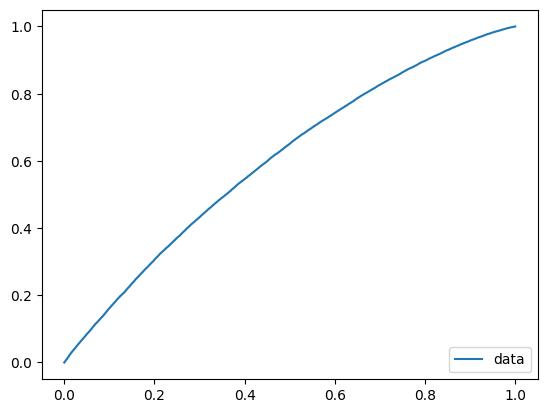

In [ ]:
from sklearn.metrics import roc_curve
X_test = df_for_logreg.loc[df_for_logreg['sample_part'] == 'test', selected_features]
y_test = df_for_logreg.loc[df_for_logreg['sample_part'] == 'test', 'target']
y_proba = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_proba)
auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr,tpr,label="data")
plt.legend(loc=4)
plt.show()

**Задание:** Визуализируйте важность фичей полученной линейной модели.

In [ ]:
import plotly.express as px
fig = px.bar(x = log_reg['clf'].feature_names_in_.tolist(),  y = log_reg['clf'].coef_.tolist())
fig.show()

####Постройте графики линейности по WoE получившегося логрега на трейне и тестовой выборке

In [ ]:
woe_line(df_for_logreg['logit_logreg'], df_for_logreg['target'], 15)

#### Постройте график стабильности `roc_auc` во времени для получившегося логрега

In [ ]:
time = df_for_logreg['quarter']
x = time
AUCs = []
for time_span in time.unique():
  y_true = df_for_logreg[time==time_span]['target']
  y_proba = df_for_logreg[time==time_span]['logreg']
  AUCs.append(roc_auc_score(y_true, y_proba))

metric_values = AUCs
metric = "AUC"
plot_title = f"{metric} plot for quarters"
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x= time.unique(),# месяцы или кварталы, your code here
        y= metric_values,# аггрегированное значение метрики, your code here
        mode='markers+lines',
        name=metric# имя фичи, your code here
        ))
fig.update_layout(
        title_text=plot_title,
        yaxis=dict(title=metric),
        width=1000,
        height=450,
        xaxis=dict(
            domain=[0, .95],
            showgrid=True,
            tickvals=time.unique()# месяцы или кварталы, your code here
            ),
        margin=dict(l=30, r=30, b=30, t=50),
        )
fig.show()

In [ ]:
time = df_for_logreg['month']
x = time
AUCs = []
for time_span in time.unique():
  y_true = df_for_logreg[time==time_span]['target']
  y_proba = df_for_logreg[time==time_span]['logreg']
  AUCs.append(roc_auc_score(y_true, y_proba))

metric_values = AUCs
metric = "AUC"
plot_title = f"{metric} plot for months"
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x= time.unique(),# месяцы или кварталы, your code here
        y= metric_values,# аггрегированное значение метрики, your code here
        mode='markers+lines',
        name=metric# имя фичи, your code here
        ))
fig.update_layout(
        title_text=plot_title,
        yaxis=dict(title=metric),
        width=1000,
        height=450,
        xaxis=dict(
            domain=[0, .95],
            showgrid=True,
            tickvals=time.unique()# месяцы или кварталы, your code here
            ),
        margin=dict(l=30, r=30, b=30, t=50),
        )
fig.show()

# Бонусная часть (3 балла)

В разделе про бустинг мы обучали `LGBMClassifier` на довольно большом наборе фичей. Их количество можно сократить, при этом не теряя в качестве модели.

За начальный набор признаков можно взять все признаки (все 230) или признаки после отбора по IV.

**Ваша задача:** Отобрать признаки, подобрать оптимальные гиперпараметры и обучить `LGBMClassifier`.

Задание творческое) Можно использовать любые методы отбора признаков / оптимизации гиперпараметров.

**Чем меньше признаков, без ухудшения качества модели – тем лучше.**

In [ ]:
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE

# Load the digits dataset

preprocessing_rfe = Pipeline([('woe', woe_transformer), ('scaling', preprocessor_pipeline) ])

X = preprocessing_rfe.fit_transform(df_for_logreg[selected_features])
y = df_for_logreg.target

log_reg_vanilla = LogisticRegression(penalty=None)
# Create the RFE object and rank each pixel
rfe = RFE(estimator=log_reg_vanilla, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_

# Plot pixel ranking
print(ranking)

[1 4 2 3 6 9 7 8 5]


In [ ]:
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE

# Load the digits dataset


X = df.dropna()[features]
y = df.dropna()[TARGET]

log_reg_vanilla = LogisticRegression(penalty=None)
# Create the RFE object and rank each pixel
rfe = RFE(estimator=log_reg_vanilla, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_

# Plot pixel ranking
print(ranking)

ValueError: could not convert string to float: 'd'

Идеи для отбора признаков:

- Воспользоваться методами из модуля `sklearn.feature_selection` (точно можно попробовать RFE). Документация https://scikit-learn.org/stable/modules/feature_selection.html
- С помощью `BorutaPy` из библиотеки `boruta` (https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a – статья может помочь разобраться с запуском алгоритма (мб не откроется без vpn))

In [ ]:
# your answere here